### Техническое задание

- Название теста: `recommender_system_test`;
- Группы: А (контрольная), B (новая платежная воронка);
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эфект: за 14 дней с момента регистрации в системе пользователи покажут лучшую конверсию в просмотр карточек товаров (событие `product_page`), просмотр  корзины товаров (событие `product_card`) и покупку (`purchase`). На каждом из шагов воронки `product_page → product_card → purchase` улучшение составит не менее 10%;
- Ожидаемое количество участников теста: 6000.

Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

# Цель: 

Проверить как повлияли изменения рекомендательной системы на количество заказов. 

### Проверка гипотезы: 

за 14 дней с момента регистрации в системе пользователи покажут лучшую конверсию в просмотр карточек товаров (событие  product_page), просмотр корзины товаров (событие product_card) и покупку (purchase). На каждом из шагов воронки product_page → product_card → purchase улучшение составит не менее 10%;
Ожидаемое количество участников теста: 6000.

# Импорт библиотек, данных и функций

In [1]:
import pandas as pd
from IPython.display import display
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
def z_test(df_a, df_b, event): 
    
    #Функция для z-теста
    
    successes = [df_a.query('event_name==@event')['user_id'].nunique(), df_b.query('event_name==@event')['user_id'].nunique()]
    trials = [df_a.query('event_name== "login"')['user_id'].nunique(), df_b.query('event_name== "login"')['user_id'].nunique()]
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [3]:
#функция для первичного анализа датасетов
def start (x):
    display(x.head()),
    print('Типы данных:')
    display(x.info()),
    print('Пропусков в данных:')
    display(x.isnull().sum()),
    print('Дубликатов в данных -', x.duplicated().sum())

In [4]:
ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')

Структура файла `ab_project_marketing_events.csv`:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [5]:
final_ab_new_users = pd.read_csv('final_ab_new_users.csv')

Структура файла `final_ab_new_users.csv`:

- `user_id` — уникальный идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион, к которому относится пользователь;
- `device` — устройство, с которого происходила регистрация.

In [6]:
final_ab_events = pd.read_csv('final_ab_events.csv')

Структура файла `final_ab_events.csv`:

- `user_id` — уникальный идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — наименование типа события;
- `details` — дополнительные данные о событии. Например, в этом поле хранится стоимость покупки (USD) для события «покупка» (`purchase`);

In [7]:
final_ab_participants = pd.read_csv('final_ab_participants.csv')

Структура файла `final_ab_participants.csv`:

- `user_id` — уникальный идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа, в которой находился пользователь в рамках теста.

## Исследовательский анализ данных 

In [8]:
#первичный анализ календаря маркетинговых активностей
start(ab_project_marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Пропусков в данных:


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Дубликатов в данных - 0


В целом данные без пропусков и дубликатов, но начало и конец маркетинговой активности - строковые. 
Лучше привести их к формату даты.  

In [9]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

In [10]:
#первичный анализ карточек пользователей 
start(final_ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Пропусков в данных:


user_id       0
first_date    0
region        0
device        0
dtype: int64

Дубликатов в данных - 0


Здесь данные тоже в порядке, стоит исправить только поле first_date на тип "даты". 

In [11]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [12]:
#первичный анализ событий клиентов
start(final_ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Пропусков в данных:


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Дубликатов в данных - 0


In [13]:
#первичный анализ событий клиентов
start(final_ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Пропусков в данных:


user_id    0
group      0
ab_test    0
dtype: int64

Дубликатов в данных - 0


К этому датасету претензий ноль. Четенько. 

# Подготовка основной таблицы

In [14]:
#к логам пользователей прибавим информацию группе и AB-тесте
ab_table = final_ab_events.merge(final_ab_participants, how = 'left', on = 'user_id')
ab_table.head()

,user_id,event_dt,event_name,details,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,NaN,NaN


Видно, что не все пользователи входят в группы нужного AB теста, а какие-то участвуют в других AB тестах. 

Лишнее можно убрать. 

In [15]:
ab_table = ab_table.query('ab_test == "recommender_system_test"')

In [16]:
#проверим все ли пользователи из европы
ab_table = ab_table.merge(final_ab_new_users, how = 'left', on = 'user_id')

In [17]:
ab_table.region.unique()

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

В тест случайно попали пользователи из CIS(?), APAC и Северной Америки. Их можно тоже откинуть. 

In [18]:
ab_table = ab_table.query('region=="EU"')

In [19]:
ab_table.shape[0]

23420

In [20]:
ab_table.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B,recommender_system_test,2020-12-07,EU,iPhone
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B,recommender_system_test,2020-12-07,EU,PC


Получилась таблица с логами событий, деталями заказа, информацией по принадлежности к группе теста, дате появления клиента, регионе и его девайсе. 

In [21]:
print('Данные начинаются с:')
display(ab_table['event_dt'].min())
print('И заканчиваются:')
ab_table['event_dt'].max()

Данные начинаются с:


'2020-12-07 00:05:57'

И заканчиваются:


'2020-12-30 12:42:57'

Из условий ТЗ: 

Дата остановки набора новых пользователей: 2020-12-21. 

Дата запуска теста: 2020-12-07

Дата остановки теста: 2021-01-04


Поэтому всех пользователей, которые появились после этой даты - в эксперимент не включаем и ставим фильтр по времени. 

In [22]:
ab_table = ab_table\
.query('first_date > "2020-12-07" & first_date < "2020-12-21"')\
.query('event_dt > "2020-12-07 00:00:00" & event_dt < "2021-01-04 23:59:59"')

In [23]:
#Всего уникальных пользователей в эксперименте
len(ab_table['user_id'].unique())

2675

По ТЗ пользователе должно было быть около 6000. Здесь сильный недобор. 

Пользователей мало, разобьем данные по группам. 

In [24]:
group_a = ab_table.query('group=="A"')

In [25]:
group_b = ab_table.query('group=="B"')

In [26]:
print('В группу А попало:')
display(len(group_a['user_id'].unique()))
print('В группу В попало:')
display(len(group_b['user_id'].unique()))

В группу А попало:


2052

В группу В попало:


623

Группы разбились неравномерно, хотя обычно для  АВ группы должны быть приблизительно одного размера, но в z-тесте речь идет о равенстве долей, поэтмоу продолжим.  
Сама группа B - слишком уж маленькая, выборка всего из шестиста человек может исказить результат из-за шумов, хотя срок у эксперимента был адекватный.



# Анализ воронок

In [27]:
#общая воронка
main_funnel = ab_table.groupby('event_name')\
    .agg({'event_name':'count', 'user_id':'nunique'})\
    .sort_values(by = 'user_id', ascending = False)
    
main_funnel['part'] = main_funnel['event_name'].apply(lambda x: ((x/main_funnel['event_name'][0])*100)).round(2)
main_funnel['events_on_user'] = (main_funnel['event_name'] /main_funnel['user_id']).round(2)
main_funnel

,event_name,user_id,part,events_on_user
event_name,,,,
login,8199,2675,100.00,3.07
product_page,5019,1661,61.21,3.02
purchase,2423,820,29.55,2.95
product_cart,2428,813,29.61,2.99


Если смотреть на всех клиентов, то видно, что конверсия довольно высокая 62% доходят до нужного продукта и 30% от общего числа - складывают его в корзину и покупают. 
По непонятным причинам покупок чуть больше, чем складываний в корзину. 
Может быть это баг? 
А может быть и фича такая. 

Каждый пользователь примерно три раза заходит на сайт, три раза успешно находит товар, три раза покупает. 
Возможно это одна группа пользователей с очень прямым клиентским путем? 

In [28]:
#воронка группы А
funnel_a = group_a.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
funnel_a['part'] = funnel_a['user_id'].apply(lambda x: ((x/funnel_a['user_id'][0])*100)).round(2)
funnel_a['events_on_user'] = (funnel_a['event_name'] /funnel_a['user_id']).round(2)

#воронка группы B
funnel_b = group_b.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
funnel_b['part'] = funnel_b['user_id'].apply(lambda x: ((x/funnel_b['user_id'][0])*100)).round(2)
funnel_b['events_on_user'] = (funnel_b['event_name'] /funnel_b['user_id']).round(2)

In [29]:
funnel_a

,event_name,user_id,part,events_on_user
event_name,,,,
login,6491,2052,100.00,3.16
product_page,4155,1326,64.62,3.13
purchase,2018,655,31.92,3.08
product_cart,1972,634,30.90,3.11


Группа А чуть более активная, чем общая группа, показывает немного большую конверсию. 

In [30]:
funnel_b

,event_name,user_id,part,events_on_user
event_name,,,,
login,1708,623,100.00,2.74
product_page,864,335,53.77,2.58
product_cart,456,179,28.73,2.55
purchase,405,165,26.48,2.45


Группа В не только значительно меньше, но и по всем показателям ощутимо проигрывает группе А. У нее значительно меньше финальная конверсия - 26,5% против 31%, эти пользователи явно холоднее относятся к сервису, новая рекомендательная система сломала то, что работало. 

Для чистоты эксперимента надо проверить присутсвуют ли в группах пользователи, которые попали в обе группы.

In [31]:
#список клиентов из группы А
g_a = list(group_a['user_id'].unique())

In [32]:
#пересечения 
group_b.query('user_id in@g_a')

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device


In [33]:
ab_table.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device
141,10C2A2FB00BD9AE2,2020-12-08 21:18:41,purchase,4.99,B,recommender_system_test,2020-12-08,EU,Android
142,8EB70A4733EED0BA,2020-12-08 11:25:39,purchase,4.99,A,recommender_system_test,2020-12-08,EU,Android
144,FBF31896CD930197,2020-12-08 13:37:43,purchase,4.99,B,recommender_system_test,2020-12-08,EU,Android
145,FCFCADE5FBB3D95A,2020-12-08 02:43:46,purchase,4.99,A,recommender_system_test,2020-12-08,EU,iPhone
146,5E26340B4933987D,2020-12-08 23:28:03,purchase,9.99,B,recommender_system_test,2020-12-08,EU,iPhone


в группах нет пересечений по пользователям

In [34]:
ab_table.groupby('user_id').agg({'group':'nunique'}).sort_values(by = 'group', ascending = False).head()

,group
user_id,
001064FEAAB631A1,1
A8294E42CCC07445,1
A8514C09C055B131,1
A8533224E9384B16,1
A880134551CFF8B7,1


In [35]:
tests = pd.read_csv('final_ab_participants.csv')

In [36]:
tests.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [37]:
tests.groupby('user_id').agg({'ab_test':'nunique'}).sort_values(by = 'ab_test', ascending = False).query('ab_test>1').shape[0]

1602

In [38]:
two_tests_users = list(tests.groupby('user_id').agg({'ab_test':'nunique'})\
.sort_values(by = 'ab_test', ascending = False)\
.query('ab_test>1').reset_index()['user_id'])

Да, действительно 1602 пользователя принимали участие в обоих тестах. 
Это тоже могло исказить результаты, учитывая, что тест называется interface_eu_test, логично, что он связан с интерфейсом и напрямую будет влиять на конверсию. 

Лучше такие смежные тесты проводить отдельно. Возможно, стоило бы выкинуть вообще пользователей в разные группы, чтобы не было пересечений между тестами, но это очен сильно уменьшит и без того небольшую выборку.

## Распределение числа событий по дням

In [39]:
#событий в день и уников 
ab_table['event_dt'] = pd.to_datetime(ab_table['event_dt'])
ab_table['event_day'] = ab_table['event_dt'].dt.date
events = ab_table.groupby('event_day').agg({'event_name':'count', 'user_id':'nunique'}).reset_index()
events

,event_day,event_name,user_id
0,2020-12-08,278,132
1,2020-12-09,482,229
2,2020-12-10,419,205
3,2020-12-11,397,204
4,2020-12-12,446,223
5,2020-12-13,386,196
6,2020-12-14,1180,545
7,2020-12-15,1187,536
8,2020-12-16,1310,578
9,2020-12-17,1428,622


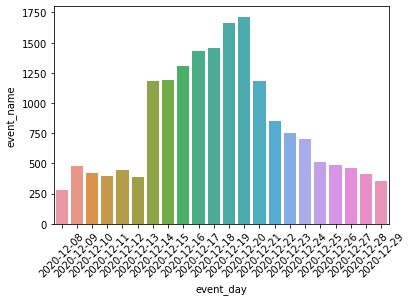

In [40]:
sns.barplot(x = 'event_day', y = 'event_name', data = events)
plt.xticks(rotation=45)
plt.show()

Большая часть активностей пользователей приходится на период с 14-го по 21-ое число, на середину эксперимента. 

In [41]:
#событий в день и уников для группы А
events_a = ab_table.query('group=="A"').groupby('event_day').agg({'event_name':'count', 'user_id':'nunique'}).reset_index()
events_a

,event_day,event_name,user_id
0,2020-12-08,196,90
1,2020-12-09,277,128
2,2020-12-10,266,125
3,2020-12-11,305,152
4,2020-12-12,297,145
5,2020-12-13,270,136
6,2020-12-14,969,441
7,2020-12-15,1002,441
8,2020-12-16,983,431
9,2020-12-17,1172,508


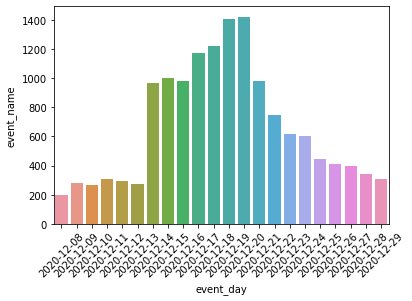

In [42]:
sns.barplot(x = 'event_day', y = 'event_name', data = events_a)
plt.xticks(rotation=45)
plt.show()

In [43]:
#событий в день и уников для группы B
events_b = ab_table.query('group=="B"').groupby('event_day').agg({'event_name':'count', 'user_id':'nunique'}).reset_index()
events_b

,event_day,event_name,user_id
0,2020-12-08,82,42
1,2020-12-09,205,101
2,2020-12-10,153,80
3,2020-12-11,92,52
4,2020-12-12,149,78
5,2020-12-13,116,60
6,2020-12-14,211,104
7,2020-12-15,185,95
8,2020-12-16,327,147
9,2020-12-17,256,114


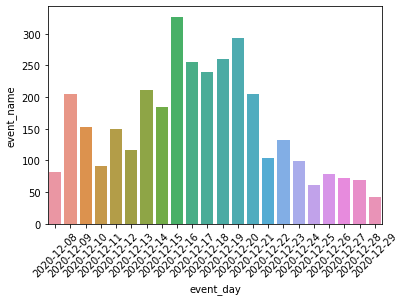

In [44]:
sns.barplot(x = 'event_day', y = 'event_name', data = events_b)
plt.xticks(rotation=45)

plt.show()

В группе В распределение числа событий более шумное. Думаю это связано со слишком маленьким размером группы. 

# AA и АВ тесты. 

## AA - тест

- Ожидаемый эфект: за 14 дней с момента регистрации в системе пользователи покажут лучшую конверсию в просмотр карточек товаров (событие `product_page`), просмотр  корзины товаров (событие `product_card`) и покупку (`purchase`). На каждом из шагов воронки `product_page → product_card → purchase` улучшение составит не менее 10%;

In [45]:
events_for_test = ['product_page', 'product_cart', 'purchase']

Для АА-теста мы случайным образом разделим группу А на выборки А_1 и А_2. Так как вся группы А была чуть больше 2000, возьмем в случайном порядке 1200 человек.

АА проводят, чтобы убедиться в том, что: 

- на результаты не влияют аномалии и выбросы в генеральной совокупности;
- инструмент «деления» трафика работает безошибочно;
- данные отправляются в системы аналитики корректно.

Если трафик делится правильно и на тест не влияют какие-то аномалии, то группы не будут отличаться, если отличаются - значит что-то не так и в исследование вмешался еще какой-то фактор.

Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1%; (возможно в нашем случае) 
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же; (возможно в нашем случае)
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости; (не про нас)
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. (не про нас, он еще в другой группе другого теста, а значит видит разные версии сайта)

Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [46]:
list_1 = group_a['user_id'].sample(1200)

group_a_1 = group_a.query('user_id in @list_1')
group_a_2 = group_a.query('user_id not in @list_1')

In [47]:
#участвуют в двух тестах в группе 
len(group_a_1.query('user_id in @two_tests_users')['user_id'].unique())/len(group_a_1['user_id'].unique())*100

24.856815578465064

In [48]:
#участвуют в двух тестах в группе 
len(group_a_2.query('user_id in @two_tests_users')['user_id'].unique())/len(group_a_2['user_id'].unique())*100

24.851569126378287

В групппах А_1 и А_2 около 25% еще участвуют в другом тесте, а значит сравнивать их через АА неправильно. 
Чтобы провести АА, лучше попробовать их сначала удалить

In [49]:
#воронка группы А_1
funnel_a_1 = group_a_1.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
funnel_a_1['part'] = funnel_a_1['user_id'].apply(lambda x: ((x/funnel_a_1['user_id'][0])*100)).round(2)
funnel_a_1['events_on_user'] = (funnel_a_1['event_name'] /funnel_a_1['user_id']).round(2)

In [50]:
#воронка группы А_2
funnel_a_2 = group_a_2.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
funnel_a_2['part'] = funnel_a_2['user_id'].apply(lambda x: ((x/funnel_a_2['user_id'][0])*100)).round(2)
funnel_a_2['events_on_user'] = (funnel_a_2['event_name'] /funnel_a_2['user_id']).round(2)

In [51]:
funnel_a_1

,event_name,user_id,part,events_on_user
event_name,,,,
login,3083,873,100.00,3.53
product_page,2269,645,73.88,3.52
purchase,1173,347,39.75,3.38
product_cart,1115,320,36.66,3.48


In [52]:
funnel_a_2

,event_name,user_id,part,events_on_user
event_name,,,,
login,3408,1179,100.00,2.89
product_page,1886,681,57.76,2.77
product_cart,857,314,26.63,2.73
purchase,845,308,26.12,2.74


In [53]:
#классика никогда не устареет
alpha = 0.05

In [54]:
for event in events_for_test:
    print('Z-тест для события', event)
    z_test(group_a_1, group_a_2, event)

Z-тест для события product_page
p-значение:  4.3076653355456074e-14
Отвергаем нулевую гипотезу: между долями есть значимая разница
Z-тест для события product_cart
p-значение:  1.1866240996472044e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Z-тест для события purchase
p-значение:  5.929190471931634e-11
Отвергаем нулевую гипотезу: между долями есть значимая разница


В целом получилось, что конверсия в АА тесте отличается слишком сильно. Такой трафик бы не прошел АА тест. 

## AB

## Тест между группами A и В. 

In [55]:
for event in events_for_test:
    print('Z-тест для события', event)
    z_test(group_a, group_b, event)

Z-тест для события product_page
p-значение:  1.0185522369976496e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Z-тест для события product_cart
p-значение:  0.30353462928670316
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Z-тест для события purchase
p-значение:  0.00996158484051235
Отвергаем нулевую гипотезу: между долями есть значимая разница


Разница в конверсиях есть, но не в пользу группы В, на воронке было четко видно, что у группы А конверсия значительно лучше. 
При этом конверсия в шаг product_cart не сильно отличается  у групп А и В.

## Тест между группами A_1 и В. 


In [56]:
for event in events_for_test:
    print('Z-тест для события', event)
    z_test(group_a_1, group_b, event)

Z-тест для события product_page
p-значение:  6.661338147750939e-16
Отвергаем нулевую гипотезу: между долями есть значимая разница
Z-тест для события product_cart
p-значение:  0.0013542477608399217
Отвергаем нулевую гипотезу: между долями есть значимая разница
Z-тест для события purchase
p-значение:  9.816652046801266e-08
Отвергаем нулевую гипотезу: между долями есть значимая разница


Ощутимые отличия. Статистически значимая разница есть. Это связано с тем, что у группы A_1 самые высокие показатели конверсии. 

## Тест между группами A_2 и В. 

In [57]:
for event in events_for_test:
    print('Z-тест для события', event)
    z_test(group_a_2, group_b, event)

Z-тест для события product_page
p-значение:  0.10439952046892631
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Z-тест для события product_cart
p-значение:  0.34176124666672103
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Z-тест для события purchase
p-значение:  0.8684619031932679
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


А вот группа А_2 показала себя хуже общей группы А и А_1. Поэтому не сильно отличается от группы B. Есть гипотеза о том, что часть трафика из группы В перетекла в группу А - возможны ошибки при маркировке. 

# Выводы: 

В подобном тестировании слишком много ошибок и неточностей. Хоть и время для эксперимента было достаточным, порядок и логика не кажутся правильными. 

Есть два способа решить проблему: можно провести заново такой тест, но уже в нужном порядке - сначала провести АА тест, потом АВ, постараться сделать группы примерно одного размера. Сроки и условия можно оставить аналогичными. 

Второй: дешевле и, наверное, надежнее, стоит признать, что разница слишком очевидная и, скорее всего, новая рекомендательная система не отрабаывает так, как надо. 

При такой высокой конверсии для группы А (31% в покупку), может вообще не стоило ничего трогать. 

Группа В не только значительно меньше, но и по всем показателям ощутимо проигрывает группе А. У нее значительно меньше финальная конверсия - 23% против 31%, эти пользователи явно холоднее относятся к сервису, новая рекомендательная система сломала то, что работало. 


По-хорошему клиентов надо бы кластеризовать с помощью ML, тогда может удасться выделить группы самых лояльных клиентов из группы А_1. 